In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque
import matplotlib.pyplot as plt

import pathlib
import numpy as np
import pandas as pd
import random

np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

            negative_avg  positive_avg  neutral_avg  total_count  new_cases
date                                                                       
2020-01-22      0.297759      0.046364     0.655877      36333.0        0.0
2020-01-23      0.496623      0.036621     0.466757     203690.0        0.0
2020-01-24      0.421975      0.053221     0.524804     568486.0        3.0
2020-01-25      0.442639      0.040343     0.517018     856089.0        1.0
2020-01-26      0.429384      0.027735     0.542881    1137737.0        4.0


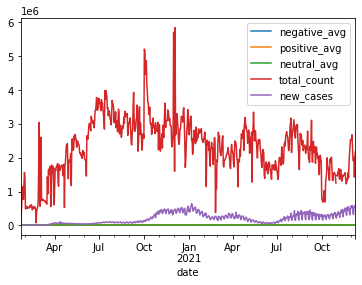

In [32]:
SENTIMENT_DATA = pathlib.Path('../data/Sent_by_day.csv')
COVID_DATA = pathlib.Path('../data/owid-covid-data.csv')
PROCESSED_DATA = pathlib.Path('../data/processed_data_unaveraged.csv')

def data_processing():
    # Check if processed data file exists
    if PROCESSED_DATA.exists():
        return pd.read_csv(PROCESSED_DATA)

    # Otherwise, process raw data
    sentiment_data = pd.read_csv(SENTIMENT_DATA, index_col=0, parse_dates=[['Year', 'Month', 'Day']])
    sentiment_data.index.rename('date', inplace=True)
    sentiment_data.drop(['Unnamed: 0'], axis=1, inplace=True)
    negative_data = sentiment_data[sentiment_data['Sentiment'] == 'negative']
    positive_data = sentiment_data[sentiment_data['Sentiment'] == 'positive']
    neutral_data = sentiment_data[sentiment_data['Sentiment'] == 'neutral']
    sentiment_data = pd.concat([negative_data, positive_data, neutral_data], axis=1, join="inner")
    sentiment_data = sentiment_data.drop(['Sentiment'], axis=1)
    sentiment_data.columns = ['negative_count', 'negative_avg', 'positive_count', 'positive_avg', 'neutral_count', 'neutral_avg']
    sentiment_data['total_count'] = sentiment_data.negative_count + sentiment_data.positive_count + sentiment_data.neutral_count
    sentiment_data.drop(['negative_count', 'positive_count', 'neutral_count'], axis=1, inplace=True)
    sentiment_data = sentiment_data.groupby(['date']).sum()

    daily_data = pd.read_csv(COVID_DATA, index_col=3, parse_dates=['date'])
    daily_data = daily_data[daily_data.continent.isin(['Europe', 'North America'])]
    daily_data = daily_data['new_cases'].groupby(daily_data.index).sum()
    daily_data = daily_data[daily_data.index >= pd.to_datetime('2020-01-22')]
    daily_data = daily_data[daily_data.index <= pd.to_datetime('2021-12-09')]

    ret = pd.concat((sentiment_data, daily_data), axis=1)
    ret.to_csv('../data/processed_data_unaveraged.csv')
    return ret

data = data_processing()
print(data.head())
data.plot()
plt.show()

In [18]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [37]:
import os
import time

model_name = "model_" + time.strftime("%Y%m%d-%H%M%S")
model = create_model(sequence_length=50, n_features=4, units=256, cell=LSTM, n_layers=5, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False)
model.summary()
checkpoint = ModelCheckpoint(os.path.join("../models", model_name), monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
data_x = data.iloc[:, :-1].to_numpy()
data_y = data.iloc[:, -1].to_numpy()

history = model.fit(data_x, data_y,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[checkpoint]
                    )

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_95 (LSTM)              (None, 50, 256)           267264    
                                                                 
 dropout_95 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_96 (LSTM)              (None, 50, 256)           525312    
                                                                 
 dropout_96 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_97 (LSTM)              (None, 50, 256)           525312    
                                                                 
 dropout_97 (Dropout)        (None, 50, 256)           0         
                                                                 
 lstm_98 (LSTM)              (None, 50, 256)         

ValueError: in user code:

    File "c:\users\jason\pycharmprojects\daisy-hackathon\venv\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\users\jason\pycharmprojects\daisy-hackathon\venv\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\jason\pycharmprojects\daisy-hackathon\venv\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\jason\pycharmprojects\daisy-hackathon\venv\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "c:\users\jason\pycharmprojects\daisy-hackathon\venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\jason\pycharmprojects\daisy-hackathon\venv\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_19" is incompatible with the layer: expected shape=(None, 50, 4), found shape=(None, 4)
